Contact: Adikrish6824@gmail.com if you have any questions

Inspired by this: https://youtu.be/83tnWs_YBRQ



This code has been heavily adapted from this notebook but modified to work with the Fission Track Dataset, It essentially splits a TIFF into its seperate images, then splits each image into its seperate parts then trains a model on each of the parts.

https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb



In [1]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/80/kgpm907s6db4tz7cvmwtd6l80000gn/T/pip-req-build-cn6ib3i7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/80/kgpm907s6db4tz7cvmwtd6l80000gn/T/pip-req-build-cn6ib3i7
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [2]:
!git add .
!git commit -m "starts redo"
!git push

[main 7946cfb] starts redo
 3 files changed, 453 insertions(+), 18 deletions(-)
 create mode 100644 .ipynb_checkpoints/Untitled-checkpoint.ipynb
 create mode 100644 Untitled.ipynb
Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 8 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 129.38 KiB | 8.63 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/RudimentaryChef/FissionTrack.git
   a4e75d9..7946cfb  main -> main


Image shape: (40, 256, 256, 3)
Mask shape: (40, 256, 256)


/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


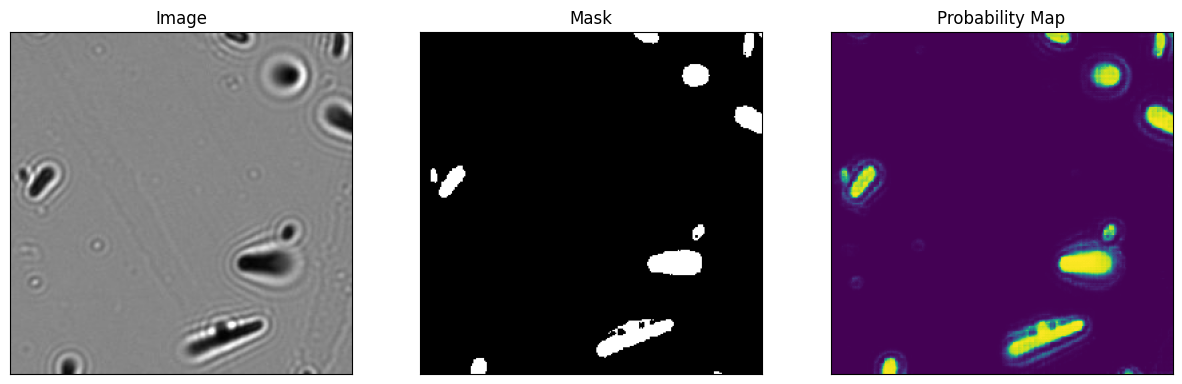

TypeError: Cannot handle this data type: (1, 1, 256, 3), |u1

In [6]:
#Assuming you've generated a working model. Here's the code needed to run it
#here's all the code in one place 
# Load tiff stack images and masks
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify, unpatchify  #Only to handle large images
import random
from scipy import ndimage
#165 large images as tiff image stack
large_images = tifffile.imread("/Users/adikrish/Desktop/Adam.tif")
large_masks = tifffile.imread("/Users/adikrish/Desktop/Eve.tif")
if large_images.ndim == 2 :
    large_images = large_images.reshape(1, large_images.shape[0], large_images.shape[1])
if large_masks.ndim == 2:
    large_masks = large_masks.reshape(1, large_masks.shape[0], large_masks.shape[1])
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256
large_images = large_images.reshape((1, 1504, 2048, 3))
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size,3), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)
images = np.squeeze(images,axis = 1)
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)
dataset[0]
def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]
    
    return bbox
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)
example = train_dataset[0]
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
batch = next(iter(train_dataloader))
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

from transformers import SamModel, SamConfig, SamProcessor
import torch
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
if(not torch.cuda.is_available()):
    my_model.load_state_dict(torch.load("/Users/adikrish/Desktop/models/Stronger_epoch3.pth", map_location = "cpu"))
else:
    my_model.load_state_dict(torch.load("/Users/adikrish/Desktop/models/Stronger_epoch3.pth", map_location = "cuda"))
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_model.to(device)
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob >= 0.44).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

def generate_and_assemble_masks(large_image):
    patches_img = patchify(large_image, (patch_size, patch_size, 3), step=step)
    reassembled_mask = np.zeros((patches_img.shape[0] * patch_size, patches_img.shape[1] * patch_size))
    print("hello")
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            test_image = Image.fromarray(single_patch_img)
            inputs = processor(test_image, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}
            my_model.eval()
            with torch.no_grad():
                outputs = my_model(**inputs, multimask_output=False)
            medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()
            medsam_seg = (medsam_seg_prob >= 0.44).astype(np.uint8)
            reassembled_mask[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = medsam_seg
    return reassembled_mask

# Generating masks for each large image
all_generated_masks = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    generated_mask = generate_and_assemble_masks(large_image)
    all_generated_masks.append(generated_mask)

# Convert the list to a numpy array
all_generated_masks = np.array(all_generated_masks)

# Visualize a generated mask
plt.imshow(all_generated_masks[0], cmap='gray')
plt.title("Generated Mask for the First Large Image")
plt.show()

starting this thing
starting process
0 5
0
1
2
3
4
5
6
7
1 5
0
1
2
3
4
5
6
7
2 5
0
1
2
3
4
5
6
7
3 5
0
1
2
3
4
5
6
7
4 5
0
1
2
3
4
5
6
7
putting all masks into an array
visualize this big boy


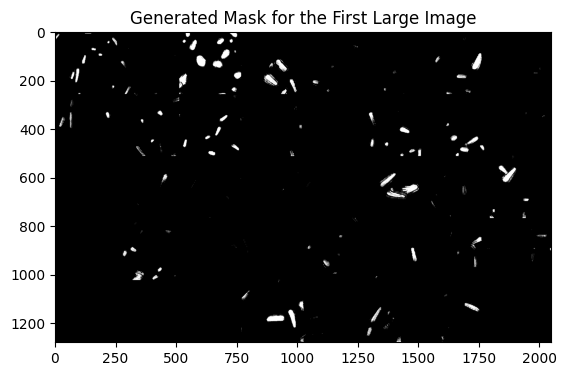

In [13]:
def generate_and_assemble_masks(large_image):
    print("starting process")
    patches_img = patchify(large_image, (patch_size, patch_size, large_image.shape[2]), step=step)
    reassembled_mask = np.zeros((patches_img.shape[0] * patch_size, patches_img.shape[1] * patch_size))
    for i in range(patches_img.shape[0]):
        print( " ".join([str(i),str(patches_img.shape[0])] ))
        for j in range(patches_img.shape[1]):
            print(j)
            single_patch_img = patches_img[i, j, 0, :, :, :]
            test_image = Image.fromarray(single_patch_img.astype(np.uint8))
            inputs = processor(test_image, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}
            my_model.eval()
            with torch.no_grad():
                outputs = my_model(**inputs, multimask_output=False)
            medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()
            medsam_seg = (medsam_seg_prob >= 0.44).astype(np.uint8)
            reassembled_mask[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = medsam_seg
    return reassembled_mask

# Generating masks for each large image
all_generated_masks = []
for img in range(large_images.shape[0]):
    print("starting this thing")
    large_image = large_images[img]
    generated_mask = generate_and_assemble_masks(large_image)
    all_generated_masks.append(generated_mask)
print("putting all masks into an array")
# Convert the list to a numpy array
all_generated_masks = np.array(all_generated_masks)
print("visualize this big boy")
# Visualize a generated mask
plt.imshow(all_generated_masks[0], cmap='gray')
plt.title("Generated Mask for the First Large Image")
plt.show()

In [9]:
!git add .
!git commit -m "attempts to functionalize code (unsuccesfully)"
!git push

[main 8526af9] attempts to functionalize code (unsuccesfully)
 1 file changed, 287 insertions(+), 65 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 8 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 329.58 KiB | 10.30 MiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/RudimentaryChef/FissionTrack.git
   b7ca5ac..8526af9  main -> main


Run this kernel to generate a model

In [29]:
#here's all the code in one place
print("start")
# Load tiff stack images and masks
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
#165 large images as tiff image stack
large_images = tifffile.imread()
large_masks = tifffile.imread()
if large_images.ndim == 2 :
    large_images = large_images.reshape(1, large_images.shape[0], large_images.shape[1])
if large_masks.ndim == 2:
    large_masks = large_masks.reshape(1, large_masks.shape[0], large_masks.shape[1])
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256
large_images = large_images.reshape((1, 1504, 2048, 3))
all_img_patches = []

for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size,3), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)
images = np.squeeze(images,axis = 1)
print("patchy images")
print(images)
print("patchy shape images")
print(images.shape)

print("patchy masks")
print(masks)
print("patchy shape images")
print(masks.shape)
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)
dataset[0]
def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]
    
    return bbox
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)
example = train_dataset[0]
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
batch = next(iter(train_dataloader))
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/Users/adikrish/Desktop/models/Other.pth")

start
patchy images
[[[[138 138 138]
   [138 138 138]
   [138 138 138]
   ...
   [139 139 139]
   [139 139 139]
   [138 138 138]]

  [[139 139 139]
   [139 139 139]
   [139 139 139]
   ...
   [142 142 142]
   [143 143 143]
   [144 144 144]]

  [[140 140 140]
   [140 140 140]
   [140 140 140]
   ...
   [140 140 140]
   [140 140 140]
   [140 140 140]]

  ...

  [[142 142 142]
   [140 140 140]
   [141 141 141]
   ...
   [141 141 141]
   [140 140 140]
   [140 140 140]]

  [[141 141 141]
   [140 140 140]
   [140 140 140]
   ...
   [142 142 142]
   [141 141 141]
   [140 140 140]]

  [[141 141 141]
   [139 139 139]
   [140 140 140]
   ...
   [143 143 143]
   [141 141 141]
   [140 140 140]]]


 [[[142 142 142]
   [142 142 142]
   [143 143 143]
   ...
   [142 142 142]
   [141 141 141]
   [139 139 139]]

  [[140 140 140]
   [141 141 141]
   [142 142 142]
   ...
   [143 143 143]
   [142 142 142]
   [141 141 141]]

  [[139 139 139]
   [140 140 140]
   [142 142 142]
   ...
   [142 142 142]
   [142 

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
 55%|███████████████████████▋                   | 11/20 [01:45<01:25,  9.56s/it]


KeyboardInterrupt: 

In [28]:
import cv2
import os

def convert_to_tif(input_folder, output_file):
    # Get a list of all files in the input folder
    files = os.listdir(input_folder)

    # Create a list to store images
    images = []

    # Loop through all files in the folder
    for file in files:
        # Check if the file is an image (you can add more extensions if needed)
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Read the image
            image_path = os.path.join(input_folder, file)
            img = cv2.imread(image_path)
            # Append the image to the list
            images.append(img)

    # Check if there are images to convert
    if images:
        # Write the images to a multi-page TIF file
        cv2.imwrite(output_file + ".tif", images[0])
        for img in images[1:]:
            print("converting image")
            cv2.imwrite(output_file + ".tif", img)
        print("Conversion completed.")
    else:
        print("No images found in the input folder.")

# Specify the input folder containing images
input_folder = "/Users/adikrish/Desktop/image_1"

# Specify the output file path for the TIF file
output_file = "/Users/adikrish/Desktop/image_1TIF"

# Call the function to convert images to TIF
convert_to_tif(input_folder, output_file)


converting image
converting image
converting image
converting image
converting image
converting image
converting image
converting image
converting image
converting image
converting image
converting image
converting image
converting image
converting image
converting image
Conversion completed.


In [19]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 11.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


Run this kernel to test the model given a random piece of data

Image shape: (40, 256, 256, 3)
Mask shape: (40, 256, 256)


/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


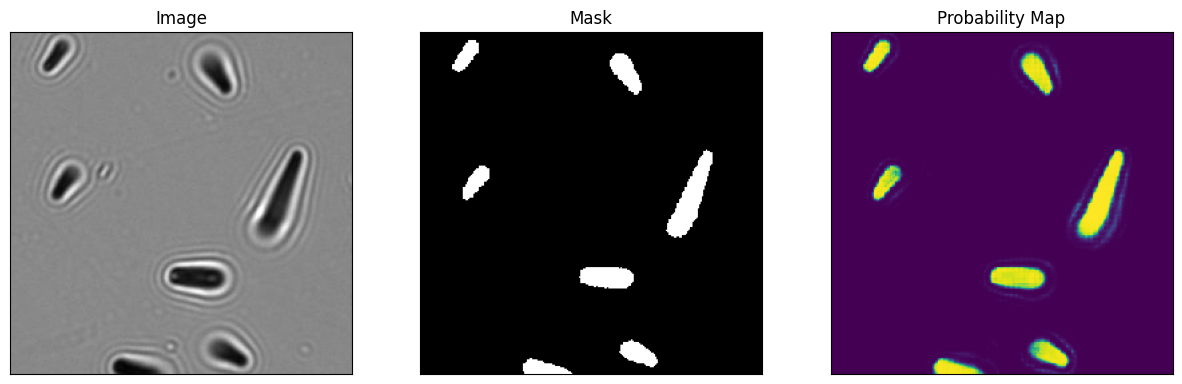

In [1]:
#here's all the code in one place 
# Load tiff stack images and masks
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
#165 large images as tiff image stack
large_images = tifffile.imread("/Users/adikrish/Desktop/Adam.tif")
large_masks = tifffile.imread("/Users/adikrish/Desktop/Eve.tif")
if large_images.ndim == 2 :
    large_images = large_images.reshape(1, large_images.shape[0], large_images.shape[1])
if large_masks.ndim == 2:
    large_masks = large_masks.reshape(1, large_masks.shape[0], large_masks.shape[1])
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256
large_images = large_images.reshape((1, 1504, 2048, 3))
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size,3), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)
images = np.squeeze(images,axis = 1)
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)
dataset[0]
def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]
    
    return bbox
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)
example = train_dataset[0]
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
batch = next(iter(train_dataloader))
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

from transformers import SamModel, SamConfig, SamProcessor
import torch
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
if(not torch.cuda.is_available()):
    my_model.load_state_dict(torch.load("/Users/adikrish/Desktop/models/Stronger_epoch3.pth", map_location = "cpu"))
else:
    my_model.load_state_dict(torch.load("/Users/adikrish/Desktop/models/Stronger_epoch3.pth", map_location = "cuda"))
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_model.to(device)
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob >= 0.44).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


**Part below is a work in progress. Its necessary to go to the next step that this portion of the code is neat. Currently it does not work DO NOT TRY TO RUN IT, but its almost there. **

In [5]:
#This attempts to functionalize this
import numpy as np
import tifffile
from patchify import patchify
from datasets import Dataset
from PIL import Image
from torch.utils.data import Dataset as TorchDataset
from transformers import SamProcessor
import monai
import torch

def load_images_and_masks(image_path, mask_path):
    large_images = tifffile.imread(image_path)
    large_masks = tifffile.imread(mask_path)
    if large_images.ndim == 2:
        large_images = large_images.reshape(1, large_images.shape[0], large_images.shape[1])
    if large_masks.ndim == 2:
        large_masks = large_masks.reshape(1, large_masks.shape[0], large_masks.shape[1])
    return large_images, large_masks

def patch_images_and_masks(images, masks, patch_size=256, step=256):
    all_img_patches = []
    for img in range(images.shape[0]):
        large_image = images[img]
        patches_img = patchify(large_image, (patch_size, patch_size, 3), step=step)
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i, j, :, :]
                all_img_patches.append(single_patch_img)
    images = np.array(all_img_patches)

    all_mask_patches = []
    for img in range(masks.shape[0]):
        large_mask = masks[img]
        patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)
        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[i, j, :, :]
                single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
                all_mask_patches.append(single_patch_mask)
    masks = np.array(all_mask_patches)
    images = np.squeeze(images, axis=1)
    return images, masks

def filter_empty_masks(images, masks):
    valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
    filtered_images = images[valid_indices]
    filtered_masks = masks[valid_indices]
    return filtered_images, filtered_masks

def create_dataset(filtered_images, filtered_masks):
    dataset_dict = {
        "image": [Image.fromarray(img) for img in filtered_images],
        "label": [Image.fromarray(mask) for mask in filtered_masks],
    }
    dataset = Dataset.from_dict(dataset_dict)
    return dataset

def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]
    
    return bbox
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs
def initialize_processor():
    return SamProcessor.from_pretrained("facebook/sam-vit-base")

def initialize_optimizer_and_loss(model):
    optimizer = torch.optim.Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
    seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
    return optimizer, seg_loss

def train_loop(model, optimizer, loss_function, train_dataloader, num_epochs=1, device="cuda"):
    model.train()
    model.to(device)
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs, multimask_output=False)
            loss = loss_function(outputs.pred_masks.squeeze(1), inputs["ground_truth_mask"].to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")

def load_model_and_processor():
    model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    my_model = SamModel(config=model_config)
    my_model.load_state_dict(torch.load("/Users/adikrish/Desktop/models/Base.pth"))
    device = "cuda" if torch.cuda.is_available() else "cpu"
    my_model.to(device)
    return my_model, processor

import numpy as np
import random
import torch
import matplotlib.pyplot as plt

def inference(model, processor, dataset, idx, threshold=0.44, device="cuda"):
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    test_image = dataset[idx]["image"]
    ground_truth_mask = np.array(dataset[idx]["label"])
    prompt = get_bounding_box(ground_truth_mask)
    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob >= threshold).astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first image on the left
    axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
    axes[0].set_title("Image")

    # Plot the second image on the right
    axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
    axes[1].set_title("Mask")

    # Plot the second image on the right
    axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
    axes[2].set_title("Probability Map")

    # Hide axis ticks and labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Display the images side by side
    plt.show()
def random_inference(model, processor, dataset, threshold=0.44, device="cuda"):
    idx = random.randint(0, len(dataset) - 1)
    test_image, medsam_seg, medsam_seg_prob = inference(model, processor, dataset, idx, threshold, device)
    return test_image, medsam_seg, medsam_seg_prob

model, processor = load_model_and_processor()
test_image, medsam_seg, medsam_seg_prob = random_inference(model, processor, dataset, device = "cpu")


NameError: name 'SamConfig' is not defined

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

Load data into numpy arrays. Here we are importing a tiff stack containing 165 images of size 768x1024. You can use glob to import multiple images from a directory or any other method. The goal is to end up with a numpy array for images and an array for masks.

In [8]:
# Load tiff stack images and masks

#165 large images as tiff image stack
large_images = tifffile.imread("/Users/adikrish/Desktop/Adam.tif")
large_masks = tifffile.imread("/Users/adikrish/Desktop/Eve.tif")


In [9]:
if large_images.ndim == 2 :
    large_images = large_images.reshape(1, large_images.shape[0], large_images.shape[1])
if large_masks.ndim == 2:
    large_masks = large_masks.reshape(1, large_masks.shape[0], large_masks.shape[1])

Now. let us divide these large images into smaller patches for training. We can use patchify or write custom code.

In [10]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

In [11]:
large_images = large_images.reshape((1, 1504, 2048, 3))

In [12]:
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size,3), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [13]:
images = np.squeeze(images,axis = 1)

In [14]:
images.shape

(40, 256, 256, 3)

In [15]:
masks.shape

(40, 256, 256)

Now, let us delete empty masks as they may cause issues later on during training. If a batch contains empty masks then the loss function will throw an error as it may not know how to handle empty tensors.

In [16]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (40, 256, 256, 3)
Mask shape: (40, 256, 256)


Let us create a 'dataset' that serves us input images and masks for the rest of our journey.

In [17]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [27]:
dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>}

Let us make sure out images and masks (labels) are loading appropriately

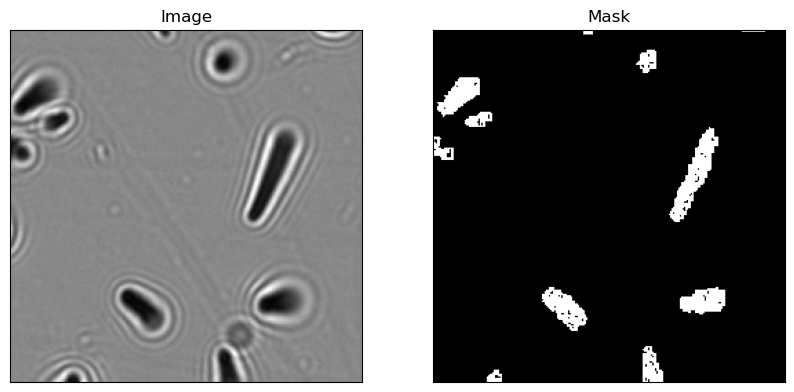

In [18]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Get bounding boxes from masks. You can get here directly if you are working with coco style annotations where bounding boxes are captured in a JSON file.

In [20]:
def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]
    
    return bbox

In [21]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [22]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [23]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [24]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [25]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [36]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [37]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [38]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [39]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [99]:
batch = next(iter(train_dataloader))
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|███████████████████████████████████████████| 20/20 [03:00<00:00,  9.03s/it]

EPOCH: 0
Mean loss: 1.5782916963100433


In [105]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/Users/adikrish/Desktop/models/Base.pth")

**Inference**

In [4]:
from transformers import SamModel, SamConfig, SamProcessor
import torch
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_model.load_state_dict(torch.load("/Users/adikrish/Desktop/models/Base.pth"))

<All keys matched successfully>

In [5]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

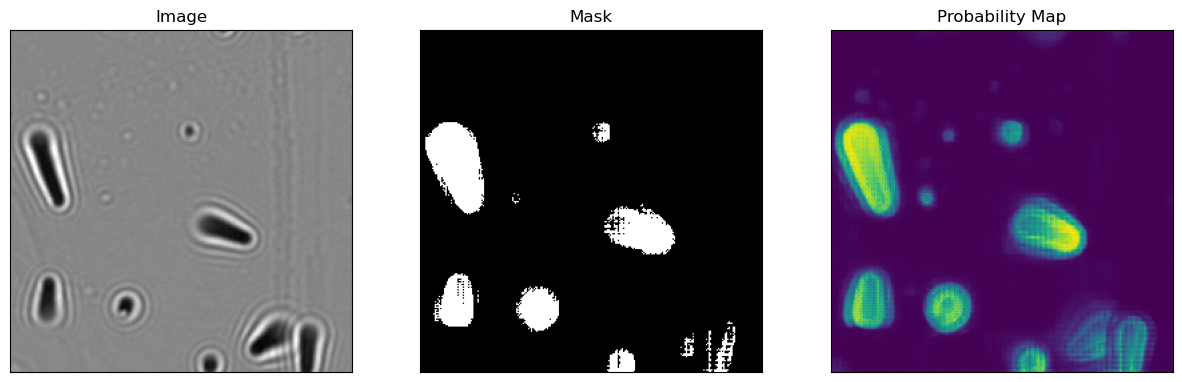

In [28]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob >= 0.44).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


Now, let us load a new image and segment it using our trained model. NOte that we need to provide some prompt. Since we do not know where the objects are going to be we cannot supply bounding boxes. So let us provide a grid of points as our prompt.

In [ ]:
#Apply a trained model on large image
large_test_images = tifffile.imread("/content/drive/MyDrive/ColabNotebooks/data/mitochondria/small_dataset_for_training/images/12_training_mito_images.tif")
large_test_image = large_test_images[1]
patches = patchify(large_test_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap


In [ ]:
"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [ ]:
print(np.array(input_points).shape)

In [ ]:
patches.shape

In [ ]:
# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.
i, j = 1, 2

# Selectelected patch for segmentation
random_array = patches[i, j]


single_patch = Image.fromarray(random_array)
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()


# forward pass
with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()